In [1]:
import pandas as pd

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.plotly as py

import seaborn as sns

import graphlab

In [2]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1518974403.log


In [3]:
graphlab.canvas.set_target('ipynb')

In [4]:
def read_data(filename):
    return pd.read_csv('/Users/mengruiyin/Downloads/' + str(filename) + '.csv')

In [5]:
def group_sort(df, groupby_col, target_col, sort_col):
     return pd.DataFrame(df.groupby(groupby_col)[target_col].count()).reset_index()\
                .sort_values(sort_col,ascending = False)

In [6]:
pd.set_option('display.max_rows',100)

In [7]:
aixsles = read_data('aisles')
department = read_data('departments')
order_prior = read_data('order_products__prior')
order_train = read_data('order_products__train')
orders = read_data('orders')
products = read_data('products')

In [8]:
# prior_data.shape

In [9]:
# prior.shape

In [10]:
# prior_data.head()

In [11]:
# prior.order_id.nunique()  #check 

In [12]:
#prior_data.groupby(['order_id','product_id']).order_id.count()

In [13]:
prior = orders[orders.eval_set == 'prior']
prior_data = prior.merge(order_prior, on = 'order_id', how = 'left')

train = orders[orders.eval_set == 'train']
train_data = train.merge(order_train, on = 'order_id', how = 'left')

test = orders[orders.eval_set == 'test']

In [14]:
dep_info = products.merge(department, on = 'department_id', how = 'left')
aisle_info = dep_info.merge(aixsles, on = 'aisle_id', how = 'left')

prior_data_da = prior_data.merge(aisle_info, on = 'product_id', how = 'left')
train_data_da = train_data.merge(aisle_info, on = 'product_id', how = 'left')
#test_data_da = test.merge(aisle_info, on = 'product_id', how = 'left')

In [15]:
na_check = pd.Series.to_frame(prior_data_da.isnull().sum())
na_check.columns = ['missing']
na_check

,missing
order_id,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,2078068
product_id,0
add_to_cart_order,0
reordered,0


By checking NA, only variable 'days_since_prior_order' has 2078068 missing value. This value is not available for the first purchase of the customers. So it is hard to do data imputation. 

In [16]:
pd.value_counts(prior_data_da['reordered'].values, sort=False)

0    13307953
1    19126536
dtype: int64

In [17]:
# order_hour = pd.DataFrame(prior_data.groupby('order_hour_of_day')['reordered'].mean())
# order_hour.columns = ['reordered_percentage']
# order_hour['order_hour'] = order_hour.index

## order hour plots

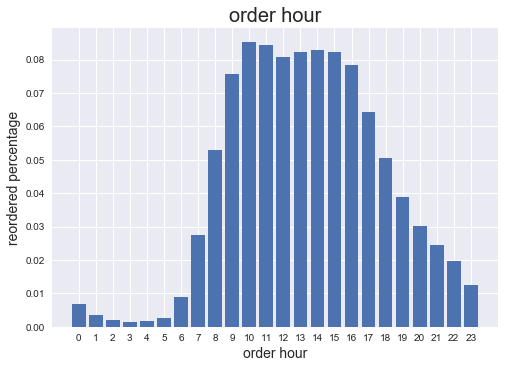

In [18]:
order_hour = group_sort(prior_data, 'order_hour_of_day', 'reordered', 'reordered')
order_hour['reordered_percentage'] = order_hour.reordered/order_hour.reordered.sum()

x = order_hour.order_hour_of_day.values

plt.bar(x,height = list(order_hour.reordered_percentage.values), width = 0.8)
plt.xticks(x,x)
plt.xlabel('order hour',fontsize = 14)
plt.ylabel('reordered percentage',fontsize = 14)
plt.title('order hour',fontsize = 20)
plt.show()

The plot shows the distribution of reordered percentage to time of order. The reordered percentage of the specific time point is calculated by number of reordered at the specific time divided the total number of reordered. From the plot, we can see shopping from 10am to 16pm have relative higher reordered percentage. 

In [19]:
pd.DataFrame(high_re.groupby('product_name')['order_id'].count()).reset_index()

NameError: name 'high_re' is not defined

I find 100 products with highest reordered percentage and made plot with order time. The plot shows most reorder behavior happens from 10am to 4pm. Most of these products are fruits and vegetables. The reorder situation of soda is very interesting. It has very high reordered percentage at 10 am which is much higher than reordered percentage of other products at 10am. However its reordered percentage is very low after 16pm, which is much lower than reordered percentage of other products. 

From the plot, we can find there are some products with relative higher reordered percentage than other products. After checking with data, we can find drinks have higher reordered percentage rate at 10 am. 

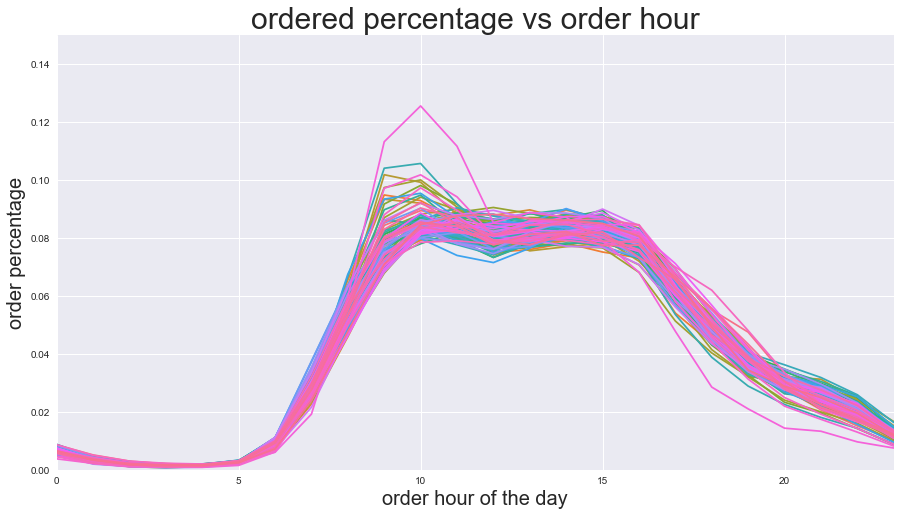

In [28]:
high_order_product = group_sort(prior_data_da, 'product_name', 'order_id','order_id')[0:100]
#high_order_product['order_percentage'] = high_order_product['order_id'] / high_order_product['order_id'].sum()

high_order = prior_data_da[prior_data_da['product_name'].isin(high_order_product.product_name.values)]

product_order_hour = pd.DataFrame(high_order.groupby(['product_name','order_hour_of_day'], as_index = False)\
                                   ['order_id'].count())
product_order_hour['ordered_percentage'] = product_order_hour.order_id/product_order_hour.groupby('product_name').order_id.transform('sum')

fig, ax = plt.subplots()

fig.set_size_inches(15, 8)
p1 = sns.tsplot(time="order_hour_of_day", value="ordered_percentage",
                 unit="product_name",condition = 'product_name',
                 data=product_order_hour)

p1.legend_.remove()

p1.axes.set_title("ordered percentage vs order hour",fontsize=30)
p1.set_xlabel("order hour of the day",fontsize=20)
p1.set_ylabel("order percentage",fontsize=20)

sns.plt.ylim(0, 0.15)
sns.plt.show()

In [24]:
order_hour100 = pd.DataFrame(high_order[['product_name','department','aisle']].drop_duplicates())
order_hour100

,product_name,department,aisle
0,Soda,beverages,soft drinks
8,Bag of Organic Bananas,produce,fresh fruits
27,Bartlett Pears,produce,fresh fruits
43,Organic Half & Half,dairy eggs,cream
56,Organic Unsweetened Almond Milk,dairy eggs,soy lactosefree
60,Organic Avocado,produce,fresh fruits
67,Uncured Genoa Salami,deli,lunch meat
68,Original Hummus,deli,fresh dips tapenades
69,Organic Raspberries,produce,packaged vegetables fruits
71,Honeycrisp Apple,produce,fresh fruits


In [25]:
order_hour1002 = graphlab.SFrame(order_hour100)
order_hour1002['department'].show()

In [26]:
order_hour1002 = graphlab.SFrame(order_hour100)
order_hour1002['aisle'].show()

In [29]:
product_order_hour.ix[product_order_hour[product_order_hour.order_hour_of_day == 10].ordered_percentage.argmax()] 

product_name              Soda
order_hour_of_day           10
order_id                  4492
ordered_percentage    0.125506
Name: 2122, dtype: object

In [30]:
product_order_hour[product_order_hour.order_hour_of_day == 10].nlargest(10, 'ordered_percentage')

,product_name,order_hour_of_day,order_id,ordered_percentage
2122,Soda,10,4492,0.125506
1306,Organic Half & Half,10,8068,0.105657
2146,Sparkling Lemon Water,10,3336,0.101745
538,Half & Half,10,6921,0.099990
442,Granny Smith Apples,10,3589,0.099179
682,Lime Sparkling Water,10,4565,0.098075
2194,Sparkling Water Grapefruit,10,7380,0.097251
1594,Organic Reduced Fat 2% Milk,10,4563,0.095382
1114,Organic Fuji Apple,10,8492,0.094743
562,Hass Avocados,10,4723,0.094044


## order day of week plots

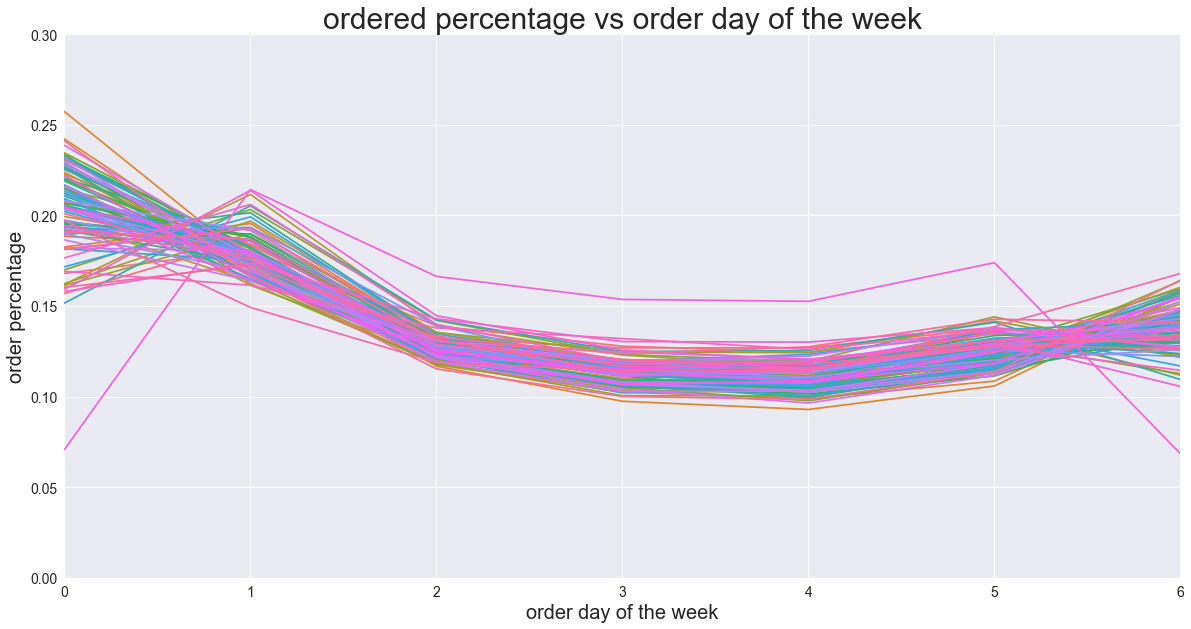

In [31]:
#high_reorder_product2 = group_sort(prior_data_da, 'product_name', 'reordered','reordered')[0:100]

#high_order_product = group_sort(prior_data_da, 'product_name', 'order_id','order_id')[0:100]

high_order2 = prior_data_da[prior_data_da['product_name'].isin(high_order_product.product_name.values)]

product_week_day = pd.DataFrame(high_order.groupby(['product_name','order_dow'], as_index = False)\
                                   ['order_id'].count())
product_week_day['ordered_percentage'] = product_week_day.order_id/product_week_day.groupby('product_name').order_id.transform('sum')

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)
p2 = sns.tsplot(time="order_dow", value="ordered_percentage",
                 unit="product_name",condition = 'product_name',
                 data=product_week_day)

p2.legend_.remove()

p2.axes.set_title("ordered percentage vs order day of the week",fontsize=30)
p2.set_xlabel("order day of the week",fontsize=20)
p2.set_ylabel("order percentage",fontsize=20)

sns.plt.xticks(fontsize=14)
sns.plt.yticks(fontsize=14)
sns.plt.ylim(0, 0.3)
sns.plt.show()

In [32]:
order_week100 = pd.DataFrame(high_order[['product_name','department','aisle']].drop_duplicates())
order_week100

,product_name,department,aisle
0,Soda,beverages,soft drinks
8,Bag of Organic Bananas,produce,fresh fruits
27,Bartlett Pears,produce,fresh fruits
43,Organic Half & Half,dairy eggs,cream
56,Organic Unsweetened Almond Milk,dairy eggs,soy lactosefree
60,Organic Avocado,produce,fresh fruits
67,Uncured Genoa Salami,deli,lunch meat
68,Original Hummus,deli,fresh dips tapenades
69,Organic Raspberries,produce,packaged vegetables fruits
71,Honeycrisp Apple,produce,fresh fruits


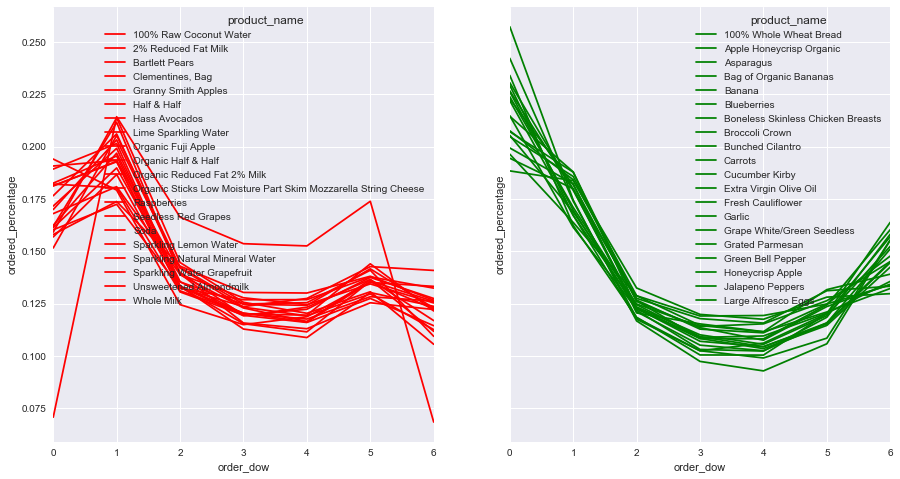

In [33]:
temp = product_week_day.merge(product_week_day, on = 'product_name', how = 'left')
temp2 = temp.ix[(temp.order_dow_x == 5) & (temp.order_dow_y  == 6) & (temp.ordered_percentage_y < temp.ordered_percentage_x)]

product_week_day['color'] = np.where(product_week_day['product_name'].isin(temp2.product_name.values),  'red', 'green')

red = product_week_day.query("color == 'red'")     # Selecting subset of rows of ROI category 
green = product_week_day.query("color == 'green'")
green_10 = pd.DataFrame(green.groupby('product_name')['order_id'].count()).reset_index()[0:20]
green_sub = green[green['product_name'].isin(green_10.product_name.values)]

f, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,8))

sns.tsplot(data=red, time="order_dow", unit="product_name",
           condition="product_name",color = red['color'], value="ordered_percentage", ax=ax[0])

sns.tsplot(data=green_sub, time="order_dow", unit="product_name",
           condition="product_name",color = green['color'], value="ordered_percentage", ax=ax[1])
sns.plt.show()



In [34]:
product_week_day.ix[product_week_day[product_week_day.order_dow == 0].ordered_percentage.argmin()] 

product_name               Soda
order_dow                     0
order_id                   2534
ordered_percentage    0.0707999
color                       red
Name: 616, dtype: object

Checking the relationship between products ordered percentage and order day of the week, I select 100 products with highest ordered percentage. Plots show two kinds of patterns of these products. So I use two subplots to plot these two patterns seperately.

The first plot(left) represents products with the first pattern of order. Most of products with the first pattern(drinks) have the highest ordered percentages on monday and the percentage keep decreasing until Thursday. The percentages of these products increase on Friday but decrease again on Saturday. Drinks usually have this kind of pattern such as water grapefruit, half&half, organic half&half. 

The second plot(right) shows the second type of pattern of orders. Products with the second type of pattern have the highest ordered percentage on Sunday and second highest ordered percentage on Saturday. The percentages of these products decrease significantly from Sunday to Monday and keep decrease until Thursday. The percentages continue to increase again from Thursday.

In general, the reodered perceantage usually increase from Thurday. Based on my analysis of order time, I can conclude that ordered pattern of drinks, especially sparking water and milk are different from other products such as fruits and vegetables, in terms of ordered hour and ordered day. Soda has very unique pattern, which is highly different than other products. Its ordered percentage is very low on Saturday and Sunday but extremely high on Monday. 


In [35]:
product_week_day2 = graphlab.SFrame(product_week_day)
product_week_day2['color'].show()

From the statistics, most of products have the second order pattern among these 100 products.

In [36]:
red_da =  prior_data_da[prior_data_da['product_name'].isin(red.product_name.values)]
red_da2 = pd.DataFrame(red_da[['product_name','department','aisle']].drop_duplicates())
red_da2

,product_name,department,aisle
0,Soda,beverages,soft drinks
27,Bartlett Pears,produce,fresh fruits
43,Organic Half & Half,dairy eggs,cream
81,Organic Sticks Low Moisture Part Skim Mozzarel...,dairy eggs,packaged cheese
218,Sparkling Lemon Water,beverages,water seltzer sparkling water
254,Granny Smith Apples,produce,fresh fruits
423,Seedless Red Grapes,produce,packaged vegetables fruits
569,Raspberries,produce,packaged produce
624,Unsweetened Almondmilk,dairy eggs,soy lactosefree
942,Sparkling Water Grapefruit,beverages,water seltzer sparkling water


In [37]:
red_da3 = graphlab.SFrame(red_da2)
red_da3['department'].show()

In [38]:
red_da3['aisle'].show()

Based on statistics, products with the first order patterns are from dairy eggs, produce and beverages departments. 20% of these products are from water aisle, 15% of these products are from fresh fruits aisle and 15% are from milk. 

In [39]:
green_da =  prior_data_da[prior_data_da['product_name'].isin(green.product_name.values)]
green_da2 = pd.DataFrame(green_da[['product_name','department','aisle']].drop_duplicates())
green_da2

,product_name,department,aisle
8,Bag of Organic Bananas,produce,fresh fruits
56,Organic Unsweetened Almond Milk,dairy eggs,soy lactosefree
60,Organic Avocado,produce,fresh fruits
67,Uncured Genoa Salami,deli,lunch meat
68,Original Hummus,deli,fresh dips tapenades
69,Organic Raspberries,produce,packaged vegetables fruits
71,Honeycrisp Apple,produce,fresh fruits
72,Strawberries,produce,fresh fruits
88,Organic Gala Apples,produce,fresh fruits
90,Banana,produce,fresh fruits


In [40]:
green_da3 = graphlab.SFrame(green_da2)
green_da3['department'].show()

In [41]:
green_da3['aisle'].show()

products with the second order pattern are mostly(75%) from produce department. Most of these products are from fresh vegetables and fresh fruits aisle. 

So, we can find products from produce department have either first order pattern or second order pattern. To find which products from produce department belong to first order pattern and which products belong to second, I list products below seperately.

In [42]:
# products from the produce department whose highest ordered percentage is on Monday

pd.DataFrame(red_da[red_da.department == 'produce'].product_name).drop_duplicates()

,product_name
27,Bartlett Pears
254,Granny Smith Apples
423,Seedless Red Grapes
569,Raspberries
1460,"Clementines, Bag"
2114,Organic Fuji Apple
3994,Hass Avocados


In [43]:
# products from the produce department whose highest ordered percentage is on Sunday

pd.DataFrame(green_da[green_da.department == 'produce'].product_name).drop_duplicates()

,product_name
8,Bag of Organic Bananas
60,Organic Avocado
69,Organic Raspberries
71,Honeycrisp Apple
72,Strawberries
88,Organic Gala Apples
90,Banana
91,Organic Hass Avocado
176,Small Hass Avocado
235,Organic Granny Smith Apple


 Similarly, products from fresh fruits aisel have either first order pattern or second order pattern. To find which products from produce department belong to first order pattern and which products belong to second, I list products below seperately.

In [44]:
# products from the fresh fruits asile whose highest ordered percentage is on Monday

pd.DataFrame(red_da[red_da.aisle == 'fresh fruits'].product_name).drop_duplicates()

,product_name
27,Bartlett Pears
254,Granny Smith Apples
2114,Organic Fuji Apple


In [45]:
# products from the fresh fruits asile whose highest ordered percentage is on Sunday

pd.DataFrame(green_da[green_da.aisle == 'fresh fruits'].product_name).drop_duplicates()

,product_name
8,Bag of Organic Bananas
60,Organic Avocado
71,Honeycrisp Apple
72,Strawberries
88,Organic Gala Apples
90,Banana
91,Organic Hass Avocado
176,Small Hass Avocado
235,Organic Granny Smith Apple
236,Organic Large Extra Fancy Fuji Apple


## order number plot

In [46]:
subprior_data_da = prior_data_da[['user_id','order_number']].drop_duplicates().sort_values('user_id')
order_number = pd.DataFrame(subprior_data_da.groupby('user_id', as_index = False)['order_number'].count())

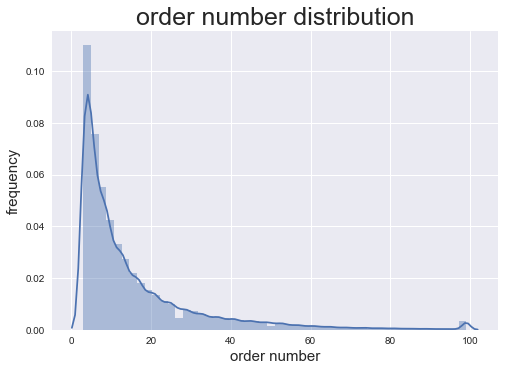

In [47]:
fig.set_size_inches(25, 15)

p3 = sns.distplot(order_number.order_number)

p3.axes.set_title("order number distribution",fontsize=25)
p3.set_xlabel("order number",fontsize=15)
p3.set_ylabel("frequency",fontsize=15)

sns.plt.show()

In [48]:
order_number2 = graphlab.SFrame(order_number)
order_number2['order_number'].show()

In [49]:
order_number.groupby('order_number').count().sort_values(['user_id'], ascending = False)

,user_id
order_number,
3,23986
4,19590
5,16165
6,13850
7,11700
8,10190
9,9032
10,7815
11,6952


## days_since_prior_order day plot

In [50]:
subprior_data_da2 = pd.DataFrame(prior_data_da[['user_id','days_since_prior_order']].\
                    groupby(['user_id','days_since_prior_order'])\
                    ['days_since_prior_order'].count())
subprior_data_da2.columns = ['count']
subprior_data_da2 = subprior_data_da2.reset_index() # NAN convert to 0 automatically
#order_number = pd.DataFrame(subprior_data_da.groupby('user_id', as_index = False)['order_number'].count())

In [51]:
high_order_user = order_number.sort_values('order_number', ascending = False)[0:100]

# high_order = prior_data_da[prior_data_da['product_name'].isin(high_order_product.product_name.values)]

# product_order_hour = pd.DataFrame(high_order.groupby(['product_name','order_hour_of_day'], as_index = False)\
#                                    ['order_id'].count())

In [ ]:
high_order_user

,user_id,order_number
152339,152340,99
185640,185641,99
185523,185524,99
81677,81678,99
70921,70922,99
136869,136870,99
81703,81704,99
119931,119932,99
119834,119835,99
91034,91035,99


In [ ]:
fig, ax = plt.subplots()

fig.set_size_inches(20, 10)
p4 = sns.tsplot(time="days_since_prior_order", value="count",
                 unit="user_id",condition = 'user_id',
                 data=subprior_data_da2)

p4.legend_.remove()

p4.axes.set_title("days since prior order day",fontsize=30)
p4.set_xlabel("days since prior order day",fontsize=20)
p4.set_ylabel("occruence times",fontsize=20)

sns.plt.xticks(fontsize=14)
sns.plt.yticks(fontsize=14)
#sns.plt.ylim(0, 0.3)
sns.plt.show()

In [ ]:
subprior_data_da2.head(100)

In [ ]:
prior_data_da.head(100)

## order aisle plot

In [245]:
def aisle_department(groupby_col,target_col, category ):
    a = prior_data_da.copy()
    a['number'] = 1
    a = pd.DataFrame(a.groupby(groupby_col)[target_col].count()).reset_index()
    a['reordered_percentage'] = a[target_col]/a.groupby(category)[target_col].transform('sum')
    b = a[a.reordered == 1] 
    b['number'] = b['number'].apply(np.log)
    return b


In [252]:
aisle_reorder = aisle_department(['aisle', 'reordered'],'number', 'aisle' )
aisle_reorder_top20 = aisle_reorder.sort_values('reordered_percentage', ascending = False)[0:20]

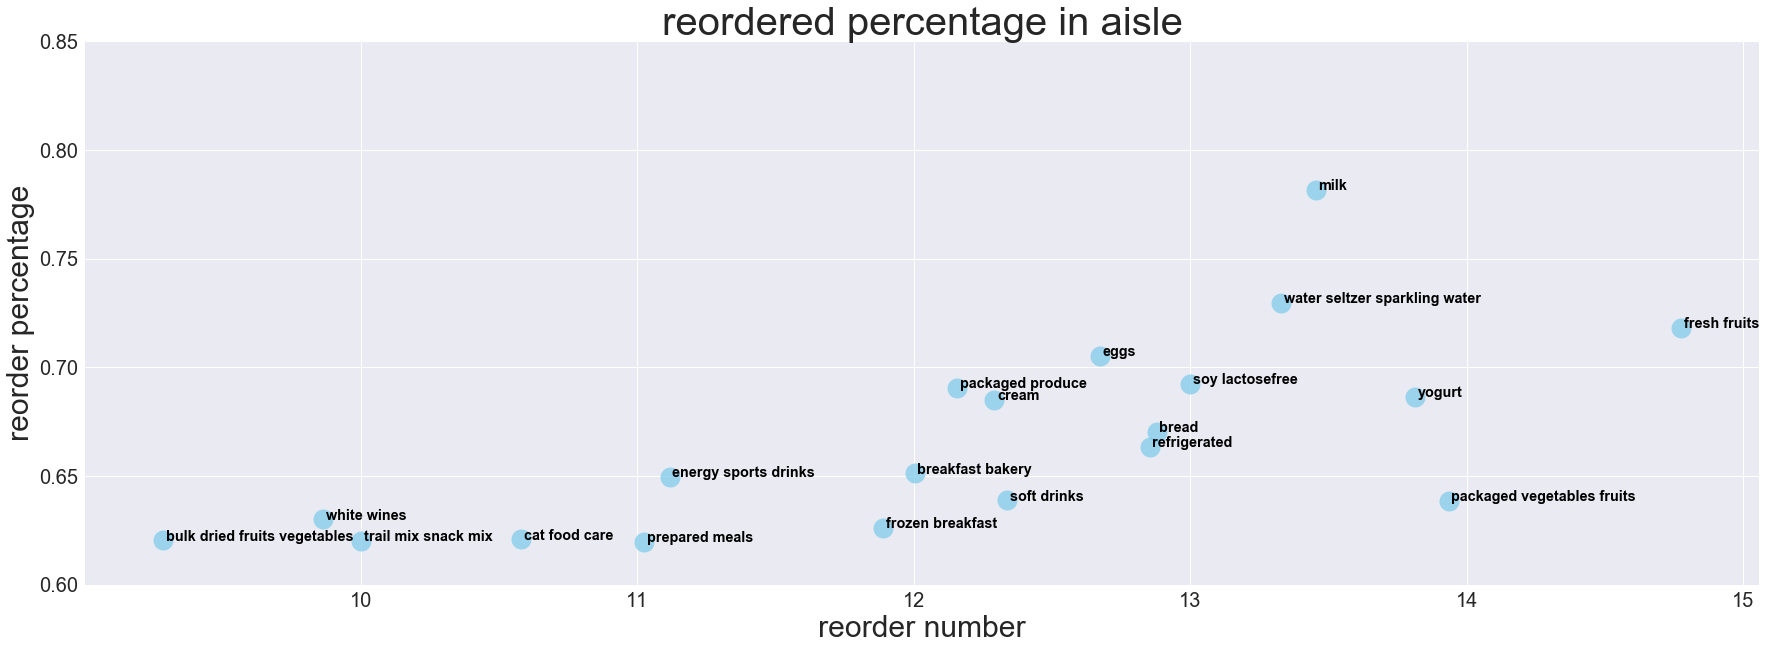

In [260]:
fig, ax = plt.subplots()

fig.set_size_inches(30, 10)

p1=sns.regplot(data=aisle_reorder_top20 , x="number", y="reordered_percentage", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,aisle_reorder_top20.shape[0]):
     p1.text(aisle_reorder_top20.number.values[line]+0.01,\
             aisle_reorder_top20.reordered_percentage.values[line],\
             aisle_reorder_top20.aisle.values[line], horizontalalignment='left',\
             size='large', color='black', weight='semibold')

p1.axes.set_title("reordered percentage in aisle",fontsize=40)
p1.set_xlabel("reorder number",fontsize=30)
p1.set_ylabel("reorder percentage",fontsize=30)
p1.tick_params(labelsize=20)
sns.plt.ylim(0.6, 0.85)

sns.plt.show() 

In [172]:
prior_data_da.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


## order department plot

In [210]:
department_reorder = aisle_department(['department', 'reordered'],'number', 'department' )

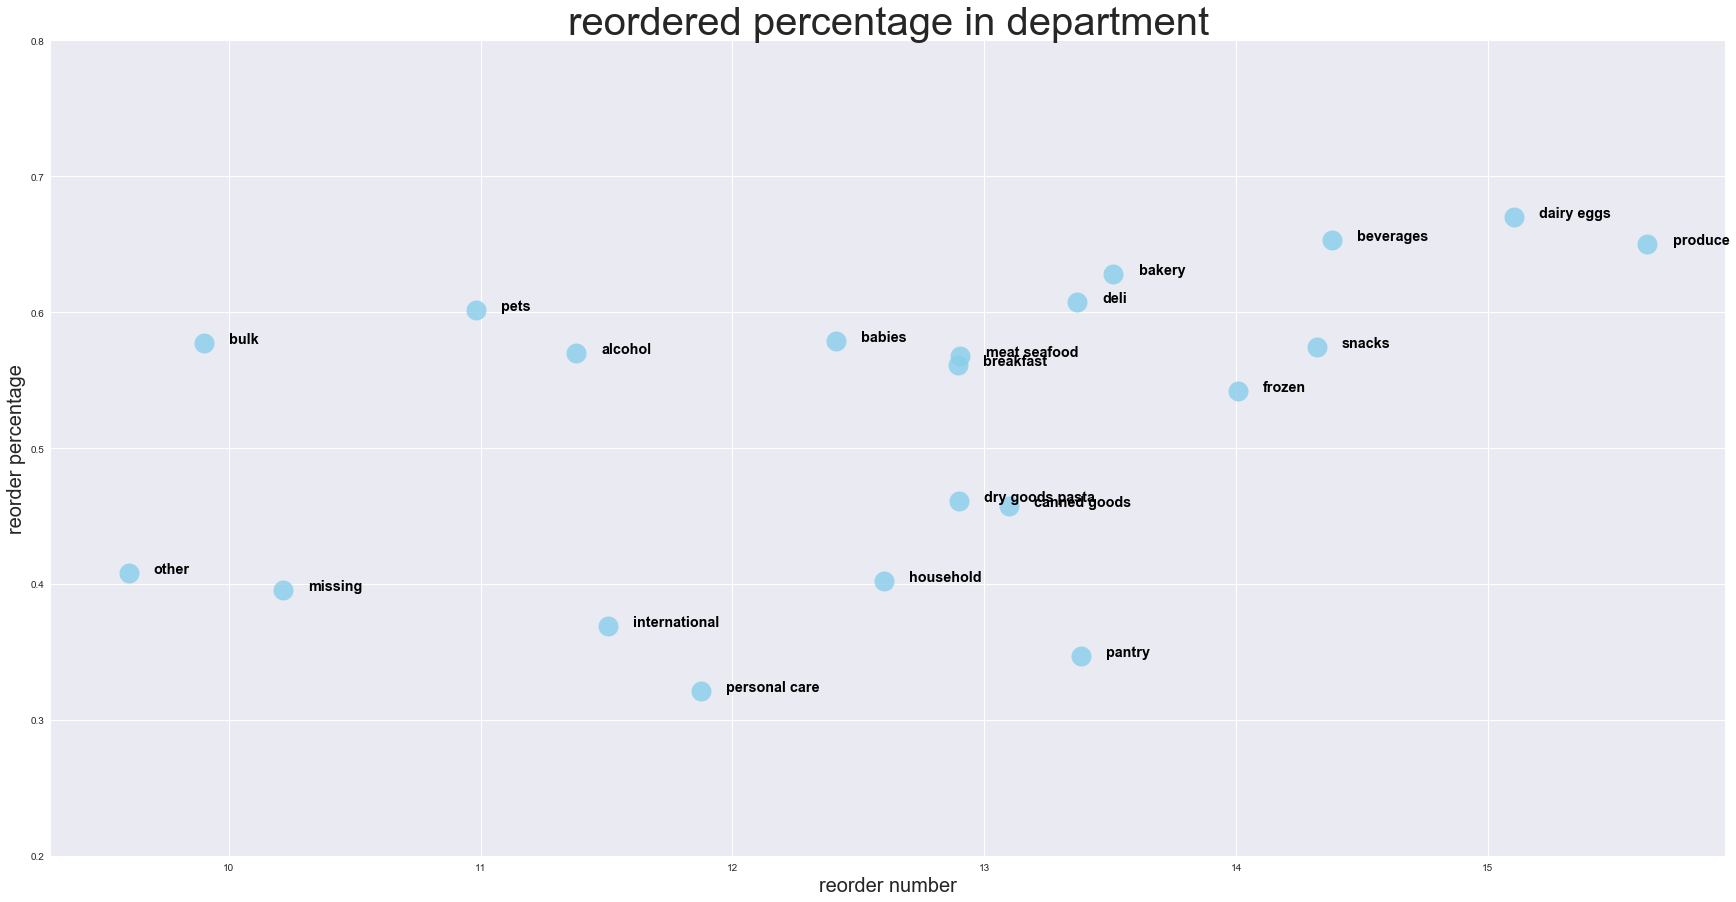

In [211]:
fig, ax = plt.subplots()

fig.set_size_inches(30, 15)

p1=sns.regplot(data=department_reorder, x="number", y="reordered_percentage", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,department_reorder.shape[0]):
     p1.text(department_reorder.number.values[line]+0.1,\
             department_reorder.reordered_percentage.values[line],\
             department_reorder.department.values[line], horizontalalignment='left',\
             size='large', color='black', weight='semibold')

p1.axes.set_title("reordered percentage in department",fontsize=40)
p1.set_xlabel("reorder number",fontsize=20)
p1.set_ylabel("reorder percentage",fontsize=20)
p1.tick_params(labelsize=10)
sns.plt.ylim(0.2, 0.8)

sns.plt.show() 

In [212]:
# department = prior_data_da.copy()
# department['number'] = 1
# department = pd.DataFrame(department.groupby(['department', 'reordered'])['number'].count()).reset_index()
# department['reordered_percentage'] = department['number']/department.groupby('department')['number'].transform('sum')
# department_reorder = department[department.reordered == 1]  
# department_reorder['number'] = department_reorder['number'].apply(np.log)
# #aisle_top20['unit'] = range(aile_top20.shape[0])

In [127]:
# fig, ax = plt.subplots()

# fig.set_size_inches(30, 15)

# p1=sns.regplot(data=department_reorder, x="number", y="reordered_percentage", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# # add annotations one by one with a loop
# for line in range(0,department_reorder.shape[0]):
#      p1.text(department_reorder.number.values[line]+0.1,\
#              department_reorder.reordered_percentage.values[line],\
#              department_reorder.department.values[line], horizontalalignment='left',\
#              size='large', color='black', weight='semibold')

# p1.axes.set_title("reordered percentage in department",fontsize=40)
# p1.set_xlabel("reorder number",fontsize=20)
# p1.set_ylabel("reorder percentage",fontsize=20)
# p1.tick_params(labelsize=10)
# sns.plt.ylim(0.2, 0.8)

# sns.plt.show() 

The plot shows reordered percentage of departments. The x-axis represents reorder number of each department and the y-axis represents reordered number of each department. From the plot, we can see bulk, pets and alcohol have relative low reordered number but high reordered percentage. It means the total order of products of these departments are not very large but once customer decide to buy the products, they have high probability to buyback. So brands effect may happen between products among these departments. Dairy eggs, beverages and products have high reordered percentages and high reordered numbers. However, the department peransal cares，households and pantry have high reorder numbers but low reorder percentage. So total order number of these products are very large. Low reorder percentages indicate elasticities of these products are very large, which means products of these departments are easy to be replaced.  

## Build a recommender

In [12]:
shopping_data = graphlab.SFrame(prior_data_da)

In [88]:
train_data_da1 = graphlab.SFrame(train_data_da)
#test1 = graphlab.SFrame(test)

In [34]:
graphlab.canvas.set_target('ipynb')

In [35]:
shopping_data['product_name'].show()

In [37]:
personalized_model = graphlab.item_similarity_recommender.create(shopping_data,
                                                                user_id = 'user_id',
                                                                 item_id = 'product_name'
                                                                )

Recsys training: model = item_similarity

Warning: Ignoring columns order_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order, product_id, add_to_cart_order, reordered, aisle_id, department_id, department, aisle;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 32434489 observations with 206209 users and 49677 items.

Training model from provided data.

Data prepared in: 19.023s

Gathering per-item and per-user statistics.

+--------------------------------+------------+

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

| 1.55ms                         | 0.25       |

| 321.016ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in 2 passes using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.04s                               | 0                | 0               |

| 8.04s                               | 0.5              | 286             |

| 9.04s                               | 1.5              | 749             |

| 10.04s                              | 2.5              | 1349            |

| 11.05s                              | 4.25             | 2113            |

| 12.05s                              | 6                | 2999            |

| 13.05s                              | 8                | 3995            |

| 14.05s                              | 10               | 5020            |

| 15.05s                              | 13               | 6509            |

| 16.05s                              | 16.25            | 8096            |

| 17.06s                              | 19.25            | 9664            |

| 18.06s                              | 22               | 10970           |

| 19.06s                              | 25.25            | 12623           |

| 20.06s                              | 29.25            | 14541           |

| 21.06s                              | 32.25            | 16048           |

| 22.07s                              | 34.25            | 17081           |

| 23.07s                              | 38               | 18890           |

| 24.07s                              | 42.5             | 21221           |

| 25.07s                              | 47               | 23366           |

| 45.16s                              | 49.75            | 24836           |

| 48.29s                              | 100              | 49677           |

Finalizing lookup tables.

+-------------------------------------+------------------+-----------------+

Generating candidate set for working with new users.

Finished training in 50.1449s

In [173]:
personalized_model.recommend(users = [1], k=5)

user_id,product_name,score,rank
1,Trail Mix,0.052385436164,1
1,Extra Fancy UnsaltedMixed Nuts ...,0.0455588599046,2
1,Crunchy Oats 'n HoneyGranola Bars ...,0.0450193815761,3
1,Organic Simply Naked PitaChips ...,0.0440532300207,4
1,Clementines,0.0431776775254,5


In [46]:
personalized_model.recommend(users = [2])

user_id,product_name,score,rank
2,Organic Strawberries,0.0384422090708,1
2,Apple Honeycrisp Organic,0.0337290109373,2
2,Organic Grape Tomatoes,0.0332140168723,3
2,Limes,0.0326036518695,4
2,Organic Garlic,0.0324381286023,5
2,Organic Baby Carrots,0.0316292848073,6
2,Organic Zucchini,0.0313808982279,7
2,Organic Baby Spinach,0.0313538383035,8
2,Organic Yellow Onion,0.0313390078498,9
2,Large Lemon,0.0311146957033,10


In [47]:
personalized_model.recommend(users = [3])

user_id,product_name,score,rank
3,Organic Zucchini,0.0702063314842,1
3,Organic Garlic,0.0688399275144,2
3,Organic Grape Tomatoes,0.0679864648617,3
3,Limes,0.0667637405973,4
3,Large Lemon,0.0667328166239,5
3,Organic Hass Avocado,0.0650621020433,6
3,Organic Yellow Onion,0.0632836475517,7
3,Organic Red Onion,0.0619085611719,8
3,Carrots,0.0595664508415,9
3,Organic Italian ParsleyBunch ...,0.0590857520248,10


In [41]:
personalized_model.get_similar_items(['Banana'])

product_name,similar,score,rank
Banana,Large Lemon,0.268943250179,1
Banana,Organic Strawberries,0.255984663963,2
Banana,Organic Avocado,0.252260923386,3
Banana,Strawberries,0.249213278294,4
Banana,Limes,0.242756724358,5
Banana,Organic Baby Spinach,0.236488938332,6
Banana,Cucumber Kirby,0.215513408184,7
Banana,Yellow Onions,0.201791346073,8
Banana,Organic Fuji Apple,0.187524557114,9
Banana,Organic Hass Avocado,0.18317681551,10


In [43]:
personalized_model.get_similar_items(['Soda'])

product_name,similar,score,rank
Soda,Clementines,0.129736840725,1
Soda,Trail Mix,0.121253669262,2
Soda,Zero Calorie Cola,0.119463860989,3
Soda,Crunchy Oats 'n HoneyGranola Bars ...,0.110260665417,4
Soda,Apples,0.0926414132118,5
Soda,Organic Simply Naked PitaChips ...,0.0870130062103,6
Soda,Drinking Water,0.0830914974213,7
Soda,Mixed Fruit Fruit Snacks,0.0787731409073,8
Soda,Popcorn,0.0774123072624,9
Soda,Orange & Lemon FlavorVariety Pack Sparkling ...,0.0758566260338,10


In [57]:
user_data = shopping_data[['user_id','order_dow','order_hour_of_day',
                           'add_to_cart_order']]
item_data = shopping_data[['product_name', 'department', 'aisle', 'reordered']]

In [68]:
personalized_model2 = graphlab.recommender.factorization_recommender.create(shopping_data.remove_column('days_since_prior_order'),
                                                                            user_id = 'user_id',
                                                                            item_id = 'product_name',
                                                                            target = 'reordered',
                                                                            user_data = user_data,
                                                                            item_data = item_data
                                                                           )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 32434489 observations with 206209 users and 49677 items.

Training factorization_recommender for recommendations.

Data prepared in: 74.192s

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 4054311 / 32434489 points for tuning the step size.

+---------+-------------------+------------------------------------------+

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

| 0       | 2.63158           | Not Viable                               |

| 1       | 0.657895          | Not Viable                               |

| 2       | 0.164474          | Not Viable                               |

| 3       | 0.0411184         | 0.144672                                 |

| 4       | 0.0205592         | 0.232153                                 |

| 5       | 0.0102796         | 0.221823                                 |

| 6       | 0.0051398         | 0.235422                                 |

| Final   | 0.0411184         | 0.144672                                 |

+---------+-------------------+------------------------------------------+

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 0.241885          | 0.491818              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 20.18s       | 0.178081          | 0.421746              | 0.0411184   |

| 2       | 39.99s       | 0.16824           | 0.409882              | 0.0411184   |

| 3       | 1m 0s        | 0.165654          | 0.406691              | 0.0411184   |

| 4       | 1m 20s       | 0.164312          | 0.40502               | 0.0411184   |

| 5       | 1m 41s       | 0.163506          | 0.404008              | 0.0411184   |

| 6       | 2m 2s        | 0.162971          | 0.403331              | 0.0411184   |

| 7       | 2m 23s       | 0.16257           | 0.402822              | 0.0411184   |

| 8       | 2m 46s       | 0.162233          | 0.402393              | 0.0411184   |

| 9       | 3m 6s        | 0.161935          | 0.402014              | 0.0411184   |

| 10      | 3m 27s       | 0.161689          | 0.4017                | 0.0411184   |

| 11      | 3m 47s       | 0.161637          | 0.401628              | 0.0411184   |

| 12      | 4m 7s        | 0.16147           | 0.401414              | 0.0411184   |

| 13      | 4m 28s       | 0.161388          | 0.401305              | 0.0411184   |

| 14      | 4m 47s       | 0.161318          | 0.401212              | 0.0411184   |

| 15      | 5m 7s        | 0.161233          | 0.4011                | 0.0411184   |

| 16      | 5m 28s       | 0.161072          | 0.400895              | 0.0411184   |

| 17      | 5m 49s       | 0.160843          | 0.400603              | 0.0411184   |

| 18      | 6m 9s        | 0.160749          | 0.400482              | 0.0411184   |

| 19      | 6m 29s       | 0.160754          | 0.400483              | 0.0411184   |

| 20      | 6m 50s       | 0.160754          | 0.400479              | 0.0411184   |

| 21      | 7m 11s       | 0.160799          | 0.400531              | 0.0411184   |

| 22      | 7m 30s       | 0.160792          | 0.400518              | 0.0411184   |

| 23      | 7m 51s       | 0.16085           | 0.400586              | 0.0411184   |

| 24      | 8m 14s       | 0.160676          | 0.400366              | 0.0411184   |

| 25      | 8m 33s       | 0.160633          | 0.400308              | 0.0411184   |

| 26      | 8m 56s       | 0.160659          | 0.400338              | 0.0411184   |

| 27      | 9m 15s       | 0.160696          | 0.40038               | 0.0411184   |

| 28      | 9m 37s       | 0.160764          | 0.400462              | 0.0411184   |

| 29      | 9m 57s       | 0.160591          | 0.400243              | 0.0411184   |

| 30      | 10m 17s      | 0.160497          | 0.400123              | 0.0411184   |

| 31      | 10m 37s      | 0.160371          | 0.399962              | 0.0411184   |

| 32      | 11m 0s       | 0.160325          | 0.399901              | 0.0411184   |

| 33      | 11m 19s      | 0.160209          | 0.399754              | 0.0411184   |

| 34      | 11m 39s      | 0.160048          | 0.399549              | 0.0411184   |

| 35      | 11m 58s      | 0.159925          | 0.399392              | 0.0411184   |

| 36      | 12m 18s      | 0.159869          | 0.399319              | 0.0411184   |

| 37      | 12m 37s      | 0.159859          | 0.399303              | 0.0411184   |

| 38      | 12m 57s      | 0.159871          | 0.399316              | 0.0411184   |

| 39      | 13m 17s      | 0.15985           | 0.399287              | 0.0411184   |

| 40      | 13m 38s      | 0.159955          | 0.399415              | 0.0411184   |

| 41      | 13m 59s      | 0.160026          | 0.399502              | 0.0411184   |

| 42      | 14m 19s      | 0.160047          | 0.399524              | 0.0411184   |

| 43      | 14m 39s      | 0.160041          | 0.399514              | 0.0411184   |

| 44      | 14m 58s      | 0.159968          | 0.399421              | 0.0411184   |

| 45      | 15m 18s      | 0.159955          | 0.399402              | 0.0411184   |

| 46      | 15m 38s      | 0.15995           | 0.399393              | 0.0411184   |

| 47      | 15m 58s      | 0.160013          | 0.399469              | 0.0411184   |

| 48      | 16m 21s      | 0.159965          | 0.399406              | 0.0411184   |

| 49      | 16m 42s      | 0.159914          | 0.399341              | 0.0411184   |

| 50      | 17m 5s       | 0.159902          | 0.399323              | 0.0411184   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.159564

Final training RMSE: 0.3989

In [69]:
personalized_model2.recommend(users = [1])

user_id,product_name,score,rank
1,Hot Buffalo Wings PotatoChips ...,1.19292601019,1
1,Eat Your VegetablesKorean Barbecue Veggie ...,1.16825780763,2
1,"Crackers, Puffed, LightlySalted Corn ...",1.15809037206,3
1,Smoked 5 Spice Tofu,1.15592778935,4
1,Traditional Multipack,1.15564091435,5
1,Minis Cheddar PretzelCrackers ...,1.14566572847,6
1,Roasted Chestnuts,1.14420080058,7
1,Rosemary & Olive OilKettle Cooked Potato ...,1.13563010232,8
1,P3 Turkey Cheese Almonds,1.13076935148,9
1,Way Better Snacks SimplySo Sweet Chili Tortilla ...,1.13056007425,10


In [70]:
personalized_model2.recommend(users = [2])

user_id,product_name,score,rank
2,Rosemary & Olive OilKettle Cooked Potato ...,1.12750554738,1
2,Turkey,1.11465358921,2
2,Cream Cheese WithJalapeño ...,1.09304418975,3
2,Raise The Roots Kombucha,1.07833462163,4
2,Hot Buffalo Wings PotatoChips ...,1.07818712947,5
2,Lightly Salted Mini RiceCrackers ...,1.06705364633,6
2,Original Whole FatLactose Free Milk ...,1.06646139665,7
2,Minis Cheddar PretzelCrackers ...,1.06390956662,8
2,Corn Chips,1.06339004602,9
2,Multigrain Pop Cakes,1.0628563054,10


In [72]:
personalized_model2.get_similar_items(['Banana'])

product_name,similar,score,rank
Banana,Vegan Alfredo SauceArtichoke ...,0.954706609249,1
Banana,Single Serve ChocolateSatin Mini Pies ...,0.95194041729,2
Banana,Pro-V Smooth and SleekConditioner 28 fl oz ...,0.947207331657,3
Banana,Fresh Scent PowerballTabs ...,0.945824801922,4
Banana,Nutrisca Lamb AndChickpea Recipe Dog Food ...,0.94563549757,5
Banana,Queso Blanco VelveetaShells & Cheese ...,0.944862306118,6
Banana,Nature's SeasonsSeasoning Blend ...,0.941519796848,7
Banana,Chicken & Vegetable MiniSpring Rolls ...,0.941285312176,8
Banana,Borax All NaturalDetergent Booster & ...,0.936716973782,9
Banana,Canola Vegetable OilBlend ...,0.935735166073,10


In [115]:
personalized_model3 = graphlab.recommender.ranking_factorization_recommender.create(shopping_data,
                                                                            user_id = 'user_id',
                                                                            item_id = 'product_name',
                                                                            user_data = user_data,
                                                                            item_data = item_data)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 32434489 observations with 206209 users and 49677 items.

Training ranking_factorization_recommender for recommendations.

Data prepared in: 91.9602s

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 4054311 / 32434489 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.5               | Not Viable                               |

| 1       | 0.625             | Not Viable                               |

| 2       | 0.15625           | Not Viable                               |

| 3       | 0.0390625         | Not Viable                               |

| 4       | 0.00976562        | No Decrease (5.87744 >= 1.38654)         |

| 5       | 0.00244141        | No Decrease (1.5821 >= 1.38654)          |

| 6       | 0.000610352       | 0.725191                                 |

| 7       | 0.000305176       | 1.0599                                   |

| 8       | 0.000152588       | 1.16067                                  |

| 9       | 7.62939e-05       | 1.23945                                  |

| Final   | 0.000610352       | 0.725191                                 |

+---------+-------------------+------------------------------------------+

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 98us         | 1.38654           | 0.693113                          |             |

| 1       | 2m 6s        | 0.814262          | 0.334877                          | 0.000610352 |

| 2       | 4m 14s       | 0.560243          | 0.219561                          | 0.000610352 |

| 3       | 6m 17s       | 0.485156          | 0.189723                          | 0.000610352 |

| 4       | 8m 21s       | 0.44757           | 0.173681                          | 0.000610352 |

| 5       | 10m 29s      | 0.437007          | 0.166194                          | 0.000610352 |

| 6       | 12m 34s      | 0.429665          | 0.162625                          | 0.000610352 |

| 7       | 14m 36s      | 0.419503          | 0.156939                          | 0.000610352 |

| 8       | 16m 46s      | 0.407811          | 0.151282                          | 0.000610352 |

| 9       | 19m 11s      | 0.39943           | 0.146655                          | 0.000610352 |

| 10      | 21m 13s      | 0.392709          | 0.142757                          | 0.000610352 |

| 11      | 23m 22s      | 0.387524          | 0.13808                           | 0.000610352 |

| 12      | 25m 26s      | 0.399082          | 0.135754                          | 0.000610352 |

| 13      | 27m 28s      | 0.419109          | 0.138293                          | 0.000610352 |

| 14      | 29m 36s      | 0.451272          | 0.142724                          | 0.000610352 |

| 15      | 31m 44s      | 0.491781          | 0.148639                          | 0.000610352 |

| 16      | 33m 46s      | 0.546365          | 0.157013                          | 0.000610352 |

| 17      | 36m 10s      | 0.612695          | 0.166848                          | 0.000610352 |

| 18      | 38m 15s      | 0.706981          | 0.181516                          | 0.000610352 |

| 19      | 40m 18s      | 0.819529          | 0.198931                          | 0.000610352 |

| 20      | 42m 23s      | 0.970866          | 0.221605                          | 0.000610352 |

| 21      | 44m 26s      | 1.14931           | 0.249898                          | 0.000610352 |

| 22      | 46m 30s      | 1.37385           | 0.284112                          | 0.000610352 |

| 23      | 1h 52m       | 1.62912           | 0.324637                          | 0.000610352 |

| 24      | 1h 57m       | 1.94676           | 0.372974                          | 0.000610352 |

| 25      | 2h 1m        | 2.27826           | 0.424926                          | 0.000610352 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 2.48276

Final training Predictive Error: 0.458261

In [122]:
personalized_model3.recommend(users = [1])

user_id,product_name,score,rank
1,Sparkling WaterGrapefruit ...,0.999714335788,1
1,Italian Sparkling MineralWater ...,0.999477646011,2
1,Lime Sparkling Water,0.99931569153,3
1,Sparkling Natural MineralWater ...,0.999295306886,4
1,Sparkling Lemon Water,0.998981314969,5
1,Frozen Organic WildBlueberries ...,0.998897631689,6
1,Organic WholeStrawberries ...,0.998802484382,7
1,Banana,0.998626832374,8
1,Blueberries,0.998477193956,9
1,Pineapple Chunks,0.998473885057,10


In [123]:
personalized_model3.recommend(users = [2])

user_id,product_name,score,rank
2,Large Lemon,0.999531849169,1
2,Sparkling WaterGrapefruit ...,0.999402053897,2
2,Organic Zucchini,0.99936911405,3
2,Yellow Onions,0.999338265422,4
2,Limes,0.999296846204,5
2,Organic Yellow Onion,0.99927283361,6
2,Organic Red Onion,0.999256985755,7
2,Organic Strawberries,0.999038797222,8
2,Italian Sparkling MineralWater ...,0.998925505422,9
2,Blueberries,0.998732217163,10


In [125]:
personalized_model3.get_similar_items(['Banana'])

product_name,similar,score,rank
Banana,Organic Strawberries,0.998817622662,1
Banana,Limes,0.998396873474,2
Banana,Bag of Organic Bananas,0.998073816299,3
Banana,Organic Avocado,0.997834384441,4
Banana,Organic Hass Avocado,0.997760117054,5
Banana,Large Lemon,0.996115386486,6
Banana,Organic Fuji Apple,0.995909750462,7
Banana,Strawberries,0.994611084461,8
Banana,Organic Blackberries,0.992759644985,9
Banana,Organic D'Anjou Pears,0.989931404591,10


In [126]:
personalized_model3.get_similar_items(['Soda'])

product_name,similar,score,rank
Soda,Coke Classic,0.993826031685,1
Soda,Zero Calorie Cola,0.991359531879,2
Soda,Organic Raw KombuchaGingerade ...,0.991155803204,3
Soda,Squeezed Lemonade,0.990894675255,4
Soda,Original No Pulp 100%Florida Orange Juice ...,0.990592122078,5
Soda,Cola Soft Drink,0.990379810333,6
Soda,Vitamin Water ZeroSqueezed Lemonade ...,0.990305066109,7
Soda,On The Go Fruit PunchDrink Mix ...,0.989480733871,8
Soda,100% Raw Coconut Water,0.9889934659,9
Soda,Orange Juice,0.988617897034,10


In [106]:
rmse = personalized_model.evaluate_rmse(train_data_da1, target = 'reordered')['rmse_overall']
recall = personalized_model.evaluate_precision_recall(train_data_da1)['precision_recall_overall']

recommendations finished on 1000/131209 queries. users per second: 2690.82

recommendations finished on 2000/131209 queries. users per second: 2489.38

recommendations finished on 3000/131209 queries. users per second: 2361.89

recommendations finished on 4000/131209 queries. users per second: 2316.43

recommendations finished on 5000/131209 queries. users per second: 2250.23

recommendations finished on 6000/131209 queries. users per second: 2184.45

recommendations finished on 7000/131209 queries. users per second: 2194.22

recommendations finished on 8000/131209 queries. users per second: 2176.33

recommendations finished on 9000/131209 queries. users per second: 2201.64

recommendations finished on 10000/131209 queries. users per second: 2201.33

recommendations finished on 11000/131209 queries. users per second: 2191.09

recommendations finished on 12000/131209 queries. users per second: 2205.3

recommendations finished on 13000/131209 queries. users per second: 2201.96

recommendations finished on 14000/131209 queries. users per second: 2197.37

recommendations finished on 15000/131209 queries. users per second: 2209.08

recommendations finished on 16000/131209 queries. users per second: 2223.21

recommendations finished on 17000/131209 queries. users per second: 2231.98

recommendations finished on 18000/131209 queries. users per second: 2241.08

recommendations finished on 19000/131209 queries. users per second: 2248.31

recommendations finished on 20000/131209 queries. users per second: 2263.22

recommendations finished on 21000/131209 queries. users per second: 2276.32

recommendations finished on 22000/131209 queries. users per second: 2283.72

recommendations finished on 23000/131209 queries. users per second: 2288.76

recommendations finished on 24000/131209 queries. users per second: 2301.75

recommendations finished on 25000/131209 queries. users per second: 2315.64

recommendations finished on 26000/131209 queries. users per second: 2328.03

recommendations finished on 27000/131209 queries. users per second: 2342.47

recommendations finished on 28000/131209 queries. users per second: 2351.91

recommendations finished on 29000/131209 queries. users per second: 2362.08

recommendations finished on 30000/131209 queries. users per second: 2373.53

recommendations finished on 31000/131209 queries. users per second: 2381.42

recommendations finished on 32000/131209 queries. users per second: 2390.28

recommendations finished on 33000/131209 queries. users per second: 2398.41

recommendations finished on 34000/131209 queries. users per second: 2405.37

recommendations finished on 35000/131209 queries. users per second: 2411.8

recommendations finished on 36000/131209 queries. users per second: 2420.29

recommendations finished on 37000/131209 queries. users per second: 2426.22

recommendations finished on 38000/131209 queries. users per second: 2432.82

recommendations finished on 39000/131209 queries. users per second: 2440.43

recommendations finished on 40000/131209 queries. users per second: 2445.51

recommendations finished on 41000/131209 queries. users per second: 2451

recommendations finished on 42000/131209 queries. users per second: 2456.69

recommendations finished on 43000/131209 queries. users per second: 2460.87

recommendations finished on 44000/131209 queries. users per second: 2461.43

recommendations finished on 45000/131209 queries. users per second: 2453.25

recommendations finished on 46000/131209 queries. users per second: 2447.82

recommendations finished on 47000/131209 queries. users per second: 2446.04

recommendations finished on 48000/131209 queries. users per second: 2440.77

recommendations finished on 49000/131209 queries. users per second: 2436.58

recommendations finished on 50000/131209 queries. users per second: 2436.79

recommendations finished on 51000/131209 queries. users per second: 2422.38

recommendations finished on 52000/131209 queries. users per second: 2419.06

recommendations finished on 53000/131209 queries. users per second: 2417.28

recommendations finished on 54000/131209 queries. users per second: 2415.57

recommendations finished on 55000/131209 queries. users per second: 2414.52

recommendations finished on 56000/131209 queries. users per second: 2410.42

recommendations finished on 57000/131209 queries. users per second: 2405.58

recommendations finished on 58000/131209 queries. users per second: 2403.76

recommendations finished on 59000/131209 queries. users per second: 2397.6

recommendations finished on 60000/131209 queries. users per second: 2391.75

recommendations finished on 61000/131209 queries. users per second: 2389.22

recommendations finished on 62000/131209 queries. users per second: 2390.54

recommendations finished on 63000/131209 queries. users per second: 2391.33

recommendations finished on 64000/131209 queries. users per second: 2390.69

recommendations finished on 65000/131209 queries. users per second: 2388.73

recommendations finished on 66000/131209 queries. users per second: 2386.36

recommendations finished on 67000/131209 queries. users per second: 2391.82

recommendations finished on 68000/131209 queries. users per second: 2394.1

recommendations finished on 69000/131209 queries. users per second: 2392.98

recommendations finished on 70000/131209 queries. users per second: 2390.96

recommendations finished on 71000/131209 queries. users per second: 2389.11

recommendations finished on 72000/131209 queries. users per second: 2388.74

recommendations finished on 73000/131209 queries. users per second: 2386.43

recommendations finished on 74000/131209 queries. users per second: 2386.16

recommendations finished on 75000/131209 queries. users per second: 2385.35

recommendations finished on 76000/131209 queries. users per second: 2390

recommendations finished on 77000/131209 queries. users per second: 2392.23

recommendations finished on 78000/131209 queries. users per second: 2397.53

recommendations finished on 79000/131209 queries. users per second: 2402.12

recommendations finished on 80000/131209 queries. users per second: 2403.4

recommendations finished on 81000/131209 queries. users per second: 2401.89

recommendations finished on 82000/131209 queries. users per second: 2405.1

recommendations finished on 83000/131209 queries. users per second: 2405.69

recommendations finished on 84000/131209 queries. users per second: 2409.19

recommendations finished on 85000/131209 queries. users per second: 2411.67

recommendations finished on 86000/131209 queries. users per second: 2414.14

recommendations finished on 87000/131209 queries. users per second: 2410.65

recommendations finished on 88000/131209 queries. users per second: 2410.46

recommendations finished on 89000/131209 queries. users per second: 2409.58

recommendations finished on 90000/131209 queries. users per second: 2409.38

recommendations finished on 91000/131209 queries. users per second: 2408.96

recommendations finished on 92000/131209 queries. users per second: 2408.72

recommendations finished on 93000/131209 queries. users per second: 2400.84

recommendations finished on 94000/131209 queries. users per second: 2402.31

recommendations finished on 95000/131209 queries. users per second: 2399.29

recommendations finished on 96000/131209 queries. users per second: 2399.67

recommendations finished on 97000/131209 queries. users per second: 2401.66

recommendations finished on 98000/131209 queries. users per second: 2398.84

recommendations finished on 99000/131209 queries. users per second: 2392.07

recommendations finished on 100000/131209 queries. users per second: 2389.95

recommendations finished on 101000/131209 queries. users per second: 2392.44

recommendations finished on 102000/131209 queries. users per second: 2396.13

recommendations finished on 103000/131209 queries. users per second: 2395.11

recommendations finished on 104000/131209 queries. users per second: 2395.71

recommendations finished on 105000/131209 queries. users per second: 2392.2

recommendations finished on 106000/131209 queries. users per second: 2393.8

recommendations finished on 107000/131209 queries. users per second: 2393.86

recommendations finished on 108000/131209 queries. users per second: 2384.99

recommendations finished on 109000/131209 queries. users per second: 2382.26

recommendations finished on 110000/131209 queries. users per second: 2379.22

recommendations finished on 111000/131209 queries. users per second: 2376.05

recommendations finished on 112000/131209 queries. users per second: 2367.22

recommendations finished on 113000/131209 queries. users per second: 2361.38

recommendations finished on 114000/131209 queries. users per second: 2357.34

recommendations finished on 115000/131209 queries. users per second: 2357.34

recommendations finished on 116000/131209 queries. users per second: 2357.63

recommendations finished on 117000/131209 queries. users per second: 2350.13

recommendations finished on 118000/131209 queries. users per second: 2349.84

recommendations finished on 119000/131209 queries. users per second: 2350.88

recommendations finished on 120000/131209 queries. users per second: 2353.26

recommendations finished on 121000/131209 queries. users per second: 2352.86

recommendations finished on 122000/131209 queries. users per second: 2353.36

recommendations finished on 123000/131209 queries. users per second: 2351.3

recommendations finished on 124000/131209 queries. users per second: 2348.93

recommendations finished on 125000/131209 queries. users per second: 2348.07

recommendations finished on 126000/131209 queries. users per second: 2348.35

recommendations finished on 127000/131209 queries. users per second: 2347.36

recommendations finished on 128000/131209 queries. users per second: 2347.89

recommendations finished on 129000/131209 queries. users per second: 2347.78

recommendations finished on 130000/131209 queries. users per second: 2345.91

recommendations finished on 131000/131209 queries. users per second: 2342.37

In [107]:
rmse

0.7651345827810391

In [102]:
recall

cutoff,precision,recall
1,0.026088149441,0.00259995766397
2,0.0243123566219,0.00481643919644
3,0.0228896899857,0.00671865904965
4,0.0216639102501,0.00837233123313
5,0.0208125966969,0.0100184988114
6,0.0200049793332,0.011482497668
7,0.0192506393834,0.0128484738306
8,0.0187287076344,0.0142333813823
9,0.0183125988139,0.0156635413733
10,0.017872249617,0.0169329572515


In [103]:
rmse2 = personalized_model2.evaluate_rmse(train_data_da1, target = 'reordered')['rmse_overall']
recall2 = personalized_model2.evaluate_precision_recall(train_data_da1)['precision_recall_overall']

recommendations finished on 1000/131209 queries. users per second: 341.84

recommendations finished on 2000/131209 queries. users per second: 340.763

recommendations finished on 3000/131209 queries. users per second: 340.921

recommendations finished on 4000/131209 queries. users per second: 340.668

recommendations finished on 5000/131209 queries. users per second: 335.034

recommendations finished on 6000/131209 queries. users per second: 332.844

recommendations finished on 7000/131209 queries. users per second: 329.194

recommendations finished on 8000/131209 queries. users per second: 323.396

recommendations finished on 9000/131209 queries. users per second: 324.73

recommendations finished on 10000/131209 queries. users per second: 325.774

recommendations finished on 11000/131209 queries. users per second: 323.674

recommendations finished on 12000/131209 queries. users per second: 320.629

recommendations finished on 13000/131209 queries. users per second: 315.404

recommendations finished on 14000/131209 queries. users per second: 313.284

recommendations finished on 15000/131209 queries. users per second: 307.312

recommendations finished on 16000/131209 queries. users per second: 303.106

recommendations finished on 17000/131209 queries. users per second: 300.193

recommendations finished on 18000/131209 queries. users per second: 295.832

recommendations finished on 19000/131209 queries. users per second: 293.278

recommendations finished on 20000/131209 queries. users per second: 292.171

recommendations finished on 21000/131209 queries. users per second: 292.374

recommendations finished on 22000/131209 queries. users per second: 293.027

recommendations finished on 23000/131209 queries. users per second: 293.324

recommendations finished on 24000/131209 queries. users per second: 293.8

recommendations finished on 25000/131209 queries. users per second: 294.236

recommendations finished on 26000/131209 queries. users per second: 292.754

recommendations finished on 27000/131209 queries. users per second: 290.497

recommendations finished on 28000/131209 queries. users per second: 288.209

recommendations finished on 29000/131209 queries. users per second: 287.283

recommendations finished on 30000/131209 queries. users per second: 286.087

recommendations finished on 31000/131209 queries. users per second: 286.256

recommendations finished on 32000/131209 queries. users per second: 286.849

recommendations finished on 33000/131209 queries. users per second: 287.271

recommendations finished on 34000/131209 queries. users per second: 286.526

recommendations finished on 35000/131209 queries. users per second: 285.487

recommendations finished on 36000/131209 queries. users per second: 284.656

recommendations finished on 37000/131209 queries. users per second: 283.824

recommendations finished on 38000/131209 queries. users per second: 284.227

recommendations finished on 39000/131209 queries. users per second: 284.794

recommendations finished on 40000/131209 queries. users per second: 285.259

recommendations finished on 41000/131209 queries. users per second: 283.994

recommendations finished on 42000/131209 queries. users per second: 283.318

recommendations finished on 43000/131209 queries. users per second: 282.88

recommendations finished on 44000/131209 queries. users per second: 282.477

recommendations finished on 45000/131209 queries. users per second: 282.082

recommendations finished on 46000/131209 queries. users per second: 282.115

recommendations finished on 47000/131209 queries. users per second: 281.899

recommendations finished on 48000/131209 queries. users per second: 281.593

recommendations finished on 49000/131209 queries. users per second: 281.534

recommendations finished on 50000/131209 queries. users per second: 281.298

recommendations finished on 51000/131209 queries. users per second: 281.295

recommendations finished on 52000/131209 queries. users per second: 281.29

recommendations finished on 53000/131209 queries. users per second: 281.359

recommendations finished on 54000/131209 queries. users per second: 281.431

recommendations finished on 55000/131209 queries. users per second: 281.228

recommendations finished on 56000/131209 queries. users per second: 281.096

recommendations finished on 57000/131209 queries. users per second: 281.422

recommendations finished on 58000/131209 queries. users per second: 281.76

recommendations finished on 59000/131209 queries. users per second: 281.567

recommendations finished on 60000/131209 queries. users per second: 281.559

recommendations finished on 61000/131209 queries. users per second: 281.449

recommendations finished on 62000/131209 queries. users per second: 281.655

recommendations finished on 63000/131209 queries. users per second: 281.754

recommendations finished on 64000/131209 queries. users per second: 281.728

recommendations finished on 65000/131209 queries. users per second: 281.873

recommendations finished on 66000/131209 queries. users per second: 281.854

recommendations finished on 67000/131209 queries. users per second: 281.76

recommendations finished on 68000/131209 queries. users per second: 281.86

recommendations finished on 69000/131209 queries. users per second: 281.786

recommendations finished on 70000/131209 queries. users per second: 281.789

recommendations finished on 71000/131209 queries. users per second: 281.805

recommendations finished on 72000/131209 queries. users per second: 281.716

recommendations finished on 73000/131209 queries. users per second: 281.343

recommendations finished on 74000/131209 queries. users per second: 281.124

recommendations finished on 75000/131209 queries. users per second: 281.157

recommendations finished on 76000/131209 queries. users per second: 280.953

recommendations finished on 77000/131209 queries. users per second: 281.087

recommendations finished on 78000/131209 queries. users per second: 281.301

recommendations finished on 79000/131209 queries. users per second: 281.377

recommendations finished on 80000/131209 queries. users per second: 281.363

recommendations finished on 81000/131209 queries. users per second: 281.196

recommendations finished on 82000/131209 queries. users per second: 281.505

recommendations finished on 83000/131209 queries. users per second: 281.696

recommendations finished on 84000/131209 queries. users per second: 281.382

recommendations finished on 85000/131209 queries. users per second: 281.119

recommendations finished on 86000/131209 queries. users per second: 281.353

recommendations finished on 87000/131209 queries. users per second: 281.617

recommendations finished on 88000/131209 queries. users per second: 281.845

recommendations finished on 89000/131209 queries. users per second: 282.086

recommendations finished on 90000/131209 queries. users per second: 282.307

recommendations finished on 91000/131209 queries. users per second: 282.083

recommendations finished on 92000/131209 queries. users per second: 281.401

recommendations finished on 93000/131209 queries. users per second: 280.799

recommendations finished on 94000/131209 queries. users per second: 280.118

recommendations finished on 95000/131209 queries. users per second: 279.481

recommendations finished on 96000/131209 queries. users per second: 279.084

recommendations finished on 97000/131209 queries. users per second: 278.57

recommendations finished on 98000/131209 queries. users per second: 277.978

recommendations finished on 99000/131209 queries. users per second: 277.526

recommendations finished on 100000/131209 queries. users per second: 277.041

recommendations finished on 101000/131209 queries. users per second: 276.696

recommendations finished on 102000/131209 queries. users per second: 276.485

recommendations finished on 103000/131209 queries. users per second: 276.17

recommendations finished on 104000/131209 queries. users per second: 275.512

recommendations finished on 105000/131209 queries. users per second: 274.929

recommendations finished on 106000/131209 queries. users per second: 274.682

recommendations finished on 107000/131209 queries. users per second: 274.52

recommendations finished on 108000/131209 queries. users per second: 274.346

recommendations finished on 109000/131209 queries. users per second: 274.201

recommendations finished on 110000/131209 queries. users per second: 273.795

recommendations finished on 111000/131209 queries. users per second: 273.448

recommendations finished on 112000/131209 queries. users per second: 273.104

recommendations finished on 113000/131209 queries. users per second: 272.761

recommendations finished on 114000/131209 queries. users per second: 272.5

recommendations finished on 115000/131209 queries. users per second: 272.185

recommendations finished on 116000/131209 queries. users per second: 271.949

recommendations finished on 117000/131209 queries. users per second: 271.704

recommendations finished on 118000/131209 queries. users per second: 271.455

recommendations finished on 119000/131209 queries. users per second: 271.179

recommendations finished on 120000/131209 queries. users per second: 270.656

recommendations finished on 121000/131209 queries. users per second: 270.117

recommendations finished on 122000/131209 queries. users per second: 269.577

recommendations finished on 123000/131209 queries. users per second: 269.056

recommendations finished on 124000/131209 queries. users per second: 268.472

recommendations finished on 125000/131209 queries. users per second: 267.693

recommendations finished on 126000/131209 queries. users per second: 266.993

recommendations finished on 127000/131209 queries. users per second: 265.875

recommendations finished on 128000/131209 queries. users per second: 264.703

recommendations finished on 129000/131209 queries. users per second: 263.486

recommendations finished on 130000/131209 queries. users per second: 262.182

recommendations finished on 131000/131209 queries. users per second: 258.597

In [104]:
rmse2

0.44936616812445185

In [105]:
recall2

cutoff,precision,recall
1,0.000251507137468,2.54438503483e-05
2,0.000278182136896,6.18369000524e-05
3,0.000297235707916,9.5177119484e-05
4,0.000299141065018,0.000130213970137
5,0.000285041422463,0.000149945497128
6,0.000284533327236,0.0001799092264
7,0.000292880605969,0.00021126338788
8,0.000304857136324,0.000244351083909
9,0.000304857136324,0.000270010010424
10,0.000314002850414,0.000307073760209


In [116]:
rmse3 = personalized_model3.evaluate_rmse(train_data_da1, target = 'reordered')['rmse_overall']
recall3 = personalized_model3.evaluate_precision_recall(train_data_da1)['precision_recall_overall']

recommendations finished on 1000/131209 queries. users per second: 178.34

recommendations finished on 2000/131209 queries. users per second: 170.859

recommendations finished on 3000/131209 queries. users per second: 164.97

recommendations finished on 4000/131209 queries. users per second: 162.448

recommendations finished on 5000/131209 queries. users per second: 160.858

recommendations finished on 6000/131209 queries. users per second: 156.487

recommendations finished on 7000/131209 queries. users per second: 153.998

recommendations finished on 8000/131209 queries. users per second: 152.489

recommendations finished on 9000/131209 queries. users per second: 151.243

recommendations finished on 10000/131209 queries. users per second: 150.325

recommendations finished on 11000/131209 queries. users per second: 150.104

recommendations finished on 12000/131209 queries. users per second: 150.405

recommendations finished on 13000/131209 queries. users per second: 151.764

recommendations finished on 14000/131209 queries. users per second: 153.682

recommendations finished on 15000/131209 queries. users per second: 154.576

recommendations finished on 16000/131209 queries. users per second: 155.938

recommendations finished on 17000/131209 queries. users per second: 156.275

recommendations finished on 18000/131209 queries. users per second: 157.337

recommendations finished on 19000/131209 queries. users per second: 158.558

recommendations finished on 20000/131209 queries. users per second: 159.69

recommendations finished on 21000/131209 queries. users per second: 160.812

recommendations finished on 22000/131209 queries. users per second: 161.691

recommendations finished on 23000/131209 queries. users per second: 162.412

recommendations finished on 24000/131209 queries. users per second: 162.712

recommendations finished on 25000/131209 queries. users per second: 163.027

recommendations finished on 26000/131209 queries. users per second: 162.873

recommendations finished on 27000/131209 queries. users per second: 163.657

recommendations finished on 28000/131209 queries. users per second: 164.522

recommendations finished on 29000/131209 queries. users per second: 165.376

recommendations finished on 30000/131209 queries. users per second: 166.253

recommendations finished on 31000/131209 queries. users per second: 167.095

recommendations finished on 32000/131209 queries. users per second: 167.851

recommendations finished on 33000/131209 queries. users per second: 168.489

recommendations finished on 34000/131209 queries. users per second: 168.985

recommendations finished on 35000/131209 queries. users per second: 169.66

recommendations finished on 36000/131209 queries. users per second: 170.288

recommendations finished on 37000/131209 queries. users per second: 169.911

recommendations finished on 38000/131209 queries. users per second: 170.067

recommendations finished on 39000/131209 queries. users per second: 169.142

recommendations finished on 40000/131209 queries. users per second: 168.816

recommendations finished on 41000/131209 queries. users per second: 169.388

recommendations finished on 42000/131209 queries. users per second: 169.973

recommendations finished on 43000/131209 queries. users per second: 170.563

recommendations finished on 44000/131209 queries. users per second: 171.086

recommendations finished on 45000/131209 queries. users per second: 171.567

recommendations finished on 46000/131209 queries. users per second: 172.084

recommendations finished on 47000/131209 queries. users per second: 172.553

recommendations finished on 48000/131209 queries. users per second: 172.92

recommendations finished on 49000/131209 queries. users per second: 171.994

recommendations finished on 50000/131209 queries. users per second: 171.866

recommendations finished on 51000/131209 queries. users per second: 171.476

recommendations finished on 52000/131209 queries. users per second: 170.922

recommendations finished on 53000/131209 queries. users per second: 170.427

recommendations finished on 54000/131209 queries. users per second: 170.76

recommendations finished on 55000/131209 queries. users per second: 170.729

recommendations finished on 56000/131209 queries. users per second: 170.866

recommendations finished on 57000/131209 queries. users per second: 171.143

recommendations finished on 58000/131209 queries. users per second: 171.436

recommendations finished on 59000/131209 queries. users per second: 171.819

recommendations finished on 60000/131209 queries. users per second: 171.996

recommendations finished on 61000/131209 queries. users per second: 172.281

recommendations finished on 62000/131209 queries. users per second: 172.62

recommendations finished on 63000/131209 queries. users per second: 172.497

recommendations finished on 64000/131209 queries. users per second: 172.726

recommendations finished on 65000/131209 queries. users per second: 172.275

recommendations finished on 66000/131209 queries. users per second: 171.576

recommendations finished on 67000/131209 queries. users per second: 171.136

recommendations finished on 68000/131209 queries. users per second: 171.277

recommendations finished on 69000/131209 queries. users per second: 171.5

recommendations finished on 70000/131209 queries. users per second: 171.872

recommendations finished on 71000/131209 queries. users per second: 172.242

recommendations finished on 72000/131209 queries. users per second: 172.601

recommendations finished on 73000/131209 queries. users per second: 172.936

recommendations finished on 74000/131209 queries. users per second: 173.307

recommendations finished on 75000/131209 queries. users per second: 173.617

recommendations finished on 76000/131209 queries. users per second: 173.743

recommendations finished on 77000/131209 queries. users per second: 173.875

recommendations finished on 78000/131209 queries. users per second: 173.443

recommendations finished on 79000/131209 queries. users per second: 173.007

recommendations finished on 80000/131209 queries. users per second: 173.314

recommendations finished on 81000/131209 queries. users per second: 173.575

recommendations finished on 82000/131209 queries. users per second: 173.84

recommendations finished on 83000/131209 queries. users per second: 174.156

recommendations finished on 84000/131209 queries. users per second: 174.451

recommendations finished on 85000/131209 queries. users per second: 174.475

recommendations finished on 86000/131209 queries. users per second: 174.612

recommendations finished on 87000/131209 queries. users per second: 174.597

recommendations finished on 88000/131209 queries. users per second: 174.673

recommendations finished on 89000/131209 queries. users per second: 174.89

recommendations finished on 90000/131209 queries. users per second: 175.108

recommendations finished on 91000/131209 queries. users per second: 175.293

recommendations finished on 92000/131209 queries. users per second: 175.49

recommendations finished on 93000/131209 queries. users per second: 175.716

recommendations finished on 94000/131209 queries. users per second: 175.93

recommendations finished on 95000/131209 queries. users per second: 176.139

recommendations finished on 96000/131209 queries. users per second: 176.354

recommendations finished on 97000/131209 queries. users per second: 176.576

recommendations finished on 98000/131209 queries. users per second: 176.787

recommendations finished on 99000/131209 queries. users per second: 176.998

recommendations finished on 100000/131209 queries. users per second: 177.178

recommendations finished on 101000/131209 queries. users per second: 177.409

recommendations finished on 102000/131209 queries. users per second: 177.628

recommendations finished on 103000/131209 queries. users per second: 177.839

recommendations finished on 104000/131209 queries. users per second: 178.054

recommendations finished on 105000/131209 queries. users per second: 178.132

recommendations finished on 106000/131209 queries. users per second: 178.331

recommendations finished on 107000/131209 queries. users per second: 178.537

recommendations finished on 108000/131209 queries. users per second: 178.742

recommendations finished on 109000/131209 queries. users per second: 178.938

recommendations finished on 110000/131209 queries. users per second: 179.134

recommendations finished on 111000/131209 queries. users per second: 179.328

recommendations finished on 112000/131209 queries. users per second: 179.511

recommendations finished on 113000/131209 queries. users per second: 179.691

recommendations finished on 114000/131209 queries. users per second: 179.881

recommendations finished on 115000/131209 queries. users per second: 180.062

recommendations finished on 116000/131209 queries. users per second: 180.262

recommendations finished on 117000/131209 queries. users per second: 180.325

recommendations finished on 118000/131209 queries. users per second: 180.035

recommendations finished on 119000/131209 queries. users per second: 179.704

recommendations finished on 120000/131209 queries. users per second: 179.504

recommendations finished on 121000/131209 queries. users per second: 179.611

recommendations finished on 122000/131209 queries. users per second: 179.783

recommendations finished on 123000/131209 queries. users per second: 179.919

recommendations finished on 124000/131209 queries. users per second: 179.574

recommendations finished on 125000/131209 queries. users per second: 179.273

recommendations finished on 126000/131209 queries. users per second: 179.024

recommendations finished on 127000/131209 queries. users per second: 178.973

recommendations finished on 128000/131209 queries. users per second: 179.131

recommendations finished on 129000/131209 queries. users per second: 179.25

recommendations finished on 130000/131209 queries. users per second: 179.329

recommendations finished on 131000/131209 queries. users per second: 178.852

In [117]:
rmse3

0.6302256039789

In [120]:
recall3

cutoff,precision,recall
1,0.0153038282435,0.0013873023883
2,0.013951024701,0.00242259218486
3,0.0135000901869,0.00344595700727
4,0.0128897407952,0.0043903551345
5,0.0124991425893,0.0053998847614
6,0.0121917449768,0.00630195403695
7,0.0117979711758,0.00710922084179
8,0.011428331898,0.00786861378814
9,0.0111128894444,0.00866563143949
10,0.0107843211975,0.00935868989122
